# An Introduction to Markov Chains
Jarod Hart

This is a Jupyter notebook intended for use in the YRCWBI Lunch and Learn.  The purpose is to give a brief introduction to Markov chains by exploring a couple examples of random walks in the Drunkard's walk and the gambler's ruin.  The purpose of the drunkard's walk example is to demonstrate how Markov chains are represented, and to become a little more familiar with their technical aspects.  The purpose of the gambler's ruin example it to begine to ask some more interesting questions about analyzing Markov chains.  In this example, we'll look at probability of absorption and time to absorption along with their computational formulas.  Finally, we'll work through a very quick example of how Google's PageRank uses Markov chains and the idea of a random walk through the web to rank its search results.

You may need to install some packages in order to execute this notebook.  All required packages are imported in the next cell.  So if you import those packages, you should be ready to rock.  All packages except for the markov package can be installed from command line using "pip install (package)".  The markov package was written in part to support this notebook, and it not available to be installed using pip.  You will need to make sure that the markov.py module is in a folder that is in your python system directory list.  Try "import sys", then "sys.path.append('filepath for markov.py')" if you're having problems with this.

In [4]:
from markov import (MarkovChain, 
                    MarkovChainState, 
                    MarkovChainEdge
                   )
import numpy as np
from matplotlib import pyplot
from scipy import sparse
import jgraph

# Drunkard's Walk

This section is on the drunkard's walk, which is a coloquial name given to a simple random walk.  

## Definition of transition matrix and initial distribution

In [5]:
# Number of states
n = 9
# Probability of stepping right (hence 1-p is the probability of stepping left)
p = .5

# Define transition matrix
P = np.zeros((n,n))
P[0,0] = 1
P[n-1,n-1] = 1
for i in range(1,n-1):
    P[i,i-1] = 1-p
    P[i,i+1] = p

# Define initial distribution
pi = np.zeros(n)
pi[int(n/2)] = 1

print('Transition matrix:')
print('P = ' + str(P) + '\n')

print('Initial distribution:')
print('pi = ' + str(pi))

Transition matrix:
P = [[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]

Initial distribution:
pi = [0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
rows,cols = np.where(P)
rows = list(rows)
cols = list(cols)

vals = [P[i,j] for i,j in zip(rows,cols)]




In [7]:

mc = MarkovChain()

for i in range(n):
    mc.add_state(state_name=f'State {i}')

    

In [8]:

for r,c,v in zip(rows,cols,vals):
    mc.add_edge(orig_state=mc.states.get(r),term_state=mc.states.get(c),transition_prob=v)


In [9]:
mc.get_communication_classes()

([[1, 2, 3, 4, 5, 6, 7], [0], [8]], ['Transient', 'Absorbing', 'Absorbing'])

In [10]:


mc.get_canonical_transition_matrix()


(<9x9 sparse matrix of type '<class 'numpy.float64'>'
 	with 16 stored elements in Compressed Sparse Row format>,
 <7x7 sparse matrix of type '<class 'numpy.float64'>'
 	with 12 stored elements in Compressed Sparse Row format>,
 <7x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>,
 <2x2 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Row format>)

In [11]:
mc.I.todense()

matrix([[1., 0.],
        [0., 1.]])

## Simulations of the drunkard's walk

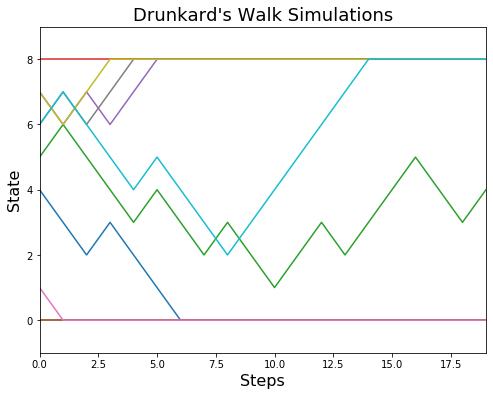

In [12]:
# P, n, and pi are carried over from the previous cell

# Number of simulations
num_sims = 10

# Number of steps simulated
num_steps = 20

RW = MarkovChain()
RW.from_nparray(P)
pyplot.figure(figsize=(8,6))
for i in range(num_sims):
    x = RW.simulate(n=num_steps,initial=pi)
    pyplot.plot(x)
pyplot.xlim([0,num_steps-1])
pyplot.ylim([-1,n])
pyplot.xlabel('Steps',fontsize=16)
pyplot.ylabel('State',fontsize=16)
pyplot.title("Drunkard's Walk Simulations",fontsize=18)
pyplot.show()


## Drunkard's walk on a doubly infinite sample space

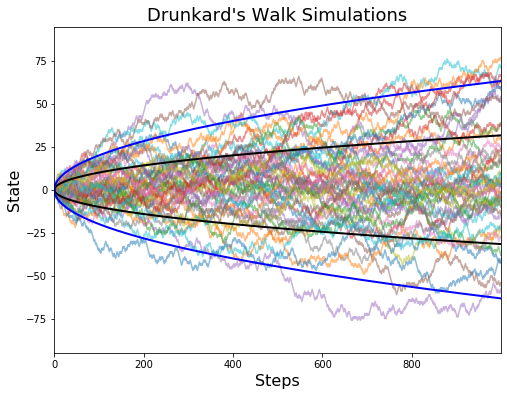

In [13]:
# Probability of stepping to the right
p = .5

# Number of simulations
num_sims = 50

# Number of steps simulated
num_steps = 1000

# Simulate random walk
pyplot.figure(figsize=(8,6))
for i in range(num_sims):
    r = np.random.choice(a=[-1,1],size=num_steps,p=[1-p,p])
    x = np.cumsum(r)
    pyplot.plot(x,alpha=.5)
    
# Plot Markov chain standard deviation in black, twice the deviation in blue
x_domain = np.array(list(range(num_steps)))
pyplot.plot(x_domain,x_domain**.5,linewidth=2,color='black')
pyplot.plot(x_domain,-x_domain**.5,linewidth=2,color='black')
pyplot.plot(x_domain,2*x_domain**.5,linewidth=2,color='blue')
pyplot.plot(x_domain,-2*x_domain**.5,linewidth=2,color='blue')
pyplot.xlim([0,num_steps-1])
pyplot.ylim([-3*num_steps**.5,3*num_steps**.5])
pyplot.xlabel('Steps',fontsize=16)
pyplot.ylabel('State',fontsize=16)
pyplot.title("Drunkard's Walk Simulations",fontsize=18)
#pyplot.savefig('your filepath and filename here.png',bbox_inches='tight')
pyplot.show()



# Gambler's Ruin
This section is about absorbing/transient states, absorption probability/times, and the gambler's ruin example.

## Simulations of the gamblers ruin

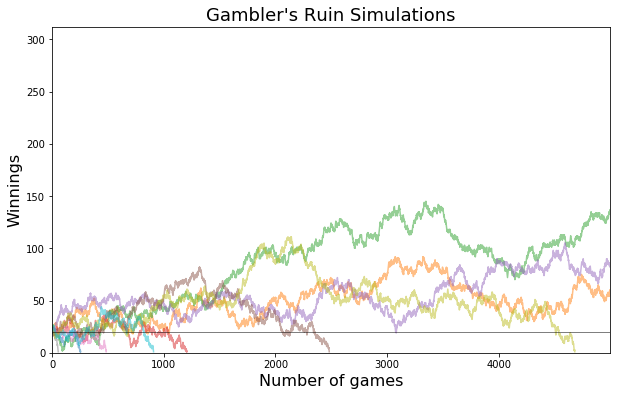

In [14]:
# Probability of stepping to the right
p = .5

# Number of simulations
num_sims = 10

# Number of steps simulated
num_games = 5000

# Initial amount of money
initial_balance = 20

# Plot simulations
pyplot.figure(figsize=(10,6))
for i in range(num_sims):
    r = np.random.choice(a=[-1,1],size=num_games,p=[1-p,p])
    x = np.cumsum(r) + initial_balance
    if 0 in x:
        x = x[:np.where(x==0)[0][0]]
    pyplot.plot(x,alpha=.5)
pyplot.plot([0,num_games],[initial_balance,initial_balance],'k-',linewidth=.5)
pyplot.xlim([0,num_games-1])
pyplot.ylim([0,100+3*num_games**.5])
pyplot.xlabel('Number of games',fontsize=16)
pyplot.ylabel('Winnings',fontsize=16)
pyplot.title("Gambler's Ruin Simulations",fontsize=18)
#pyplot.savefig('your filepath and filename.png',bbox_inches='tight')
pyplot.show()



In [19]:
# Number of states
n = 9

# Probability of stepping to the right
p = .5

# Define transition matrix
P = np.zeros((n,n))
P[0,0] = 1
P[n-1,n-1] = 1
for i in range(1,n-1):
    P[i,i-1] = 1-p
    P[i,i+1] = p

# Define initial distribution
pi = np.zeros(n)
pi[int(n/2)] = 1

# Create Markov chain object and compute relevant quantities
RW = MarkovChain()
RW.from_nparray(P)
# RW = RW.analyze()

RW.get_communication_classes()
RW.get_transition_matrix_decomposition()
RW.get_canonical_transition_matrix()
RW.get_expected_visits_matrix()
RW.get_absorption_probability_matrix()
RW.get_expected_time_to_absorption_matrix()


print('Transition matrix: ' + str(RW.csr_transition_matrix.todense()) + '\n')
print('Communication classes: ' + str(RW.classes) + '\n')
print('Communication classe types: ' + str(RW.types) + '\n')

print('Fundamental matrix (expected number of visits)')
print('N = ' + str(RW.N.todense()) + '\n')
print('Probability of absorption')
print('B = ' + str(RW.B.todense()) + '\n')
print('Expected absorption times')
print('T = ' + str(RW.T.todense()) + '\n')
print('Full canonical matrix')
print('A = ' + str(RW.canonical_transition_matrix.todense()) + '\n')

Transition matrix: [[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]

Communication classes: [[1, 2, 3, 4, 5, 6, 7], [0], [8]]

Communication classe types: ['Transient', 'Absorbing', 'Absorbing']

Fundamental matrix (expected number of visits)
N = [[1.75 1.5  1.25 1.   0.75 0.5  0.25]
 [1.5  3.   2.5  2.   1.5  1.   0.5 ]
 [1.25 2.5  3.75 3.   2.25 1.5  0.75]
 [1.   2.   3.   4.   3.   2.   1.  ]
 [0.75 1.5  2.25 3.   3.75 2.5  1.25]
 [0.5  1.   1.5  2.   2.5  3.   1.5 ]
 [0.25 0.5  0.75 1.   1.25 1.5  1.75]]

Probability of absorption
B = [[0.875 0.125]
 [0.75  0.25 ]
 [0.625 0.375]
 [0.5   0.5  ]
 [0.375 0.625]
 [0.25  0.75 ]
 [0.125 0.875]]

Expected absorption times
T = [[ 7.]
 [12.]
 

## Gambler's ruin with walk-away exit strategy simulations

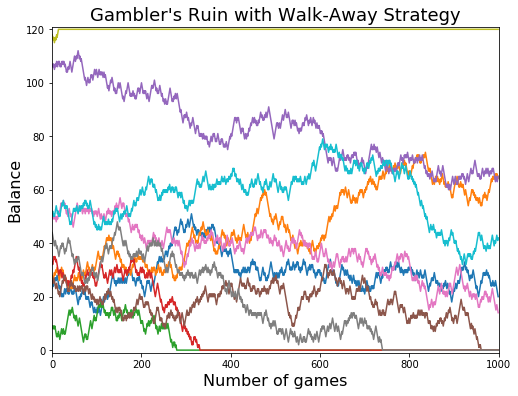

In [22]:
# Probability of winning
p = .5

# Initial amount of money
initial_balance = 20

# Number of states
walk_away_num = 120

# Number of simulations
num_sims = 10

# Number of games to play
num_games = 1000


# Number of state in the model (broke, walk-away number, and all integers in-between)
n = walk_away_num + 1

# Define transition matrix
P = np.zeros((n,n))
P[0,0] = 1
P[n-1,n-1] = 1
for i in range(1,n-1):
    P[i,i-1] = 1-p
    P[i,i+1] = p

# Define initial distribution
pi = np.zeros(n)
pi[initial_balance] = 1

# Create Markov chain object and compute relevant quantities
RW = MarkovChain()
RW.from_nparray(P)

RW.get_communication_classes()
RW.get_transition_matrix_decomposition()
RW.get_canonical_transition_matrix()
RW.get_expected_visits_matrix()
RW.get_absorption_probability_matrix()
RW.get_expected_time_to_absorption_matrix()

pyplot.figure(figsize=(8,6))
for i in range(num_sims):
    x = RW.simulate(n=num_games,initial=pi)
    pyplot.plot(x)
pyplot.xlim([0,num_games])
pyplot.ylim([-1,n])
pyplot.xlabel('Number of games',fontsize=16)
pyplot.ylabel('Balance',fontsize=16)
pyplot.title("Gambler's Ruin with Walk-Away Strategy",fontsize=18)
pyplot.show()


## Gambler's ruin with walk-away exit strategy analysis

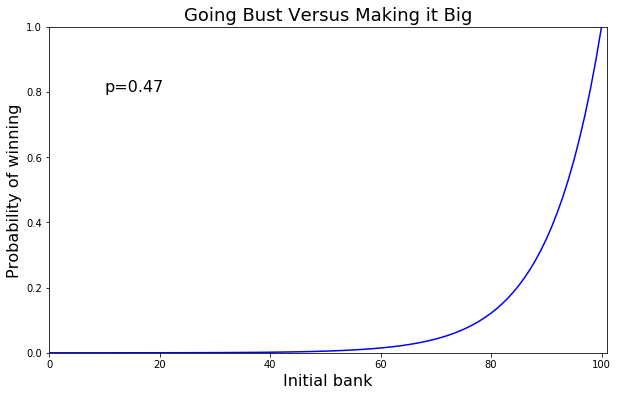

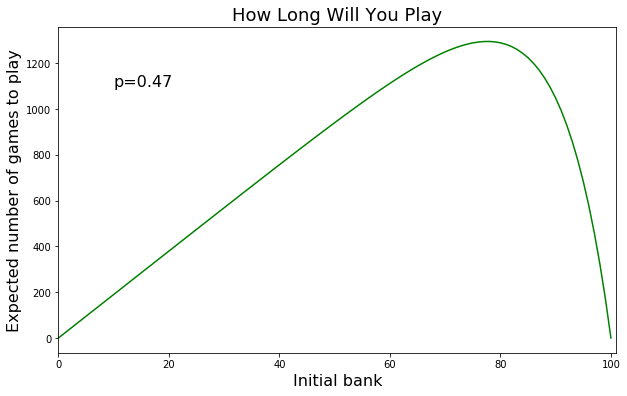

In [24]:
# Probability of winning
p = 18/38

# Number of states
walk_away_num = 100

# Number of games to play
num_games = 1000

# Number of state in the model (broke, walk-away number, and all integers in-between)
n = walk_away_num + 1

# Define transition matrix
P = np.zeros((n,n))
P[0,0] = 1
P[n-1,n-1] = 1
for i in range(1,n-1):
    P[i,i-1] = 1-p
    P[i,i+1] = p
pi = np.zeros(n)
pi[5] = 1

# Make Markov chain object
RW = MarkovChain()
RW.from_nparray(P)

RW.get_communication_classes()
RW.get_transition_matrix_decomposition()
RW.get_canonical_transition_matrix()
RW.get_expected_visits_matrix()
RW.get_absorption_probability_matrix()
RW.get_expected_time_to_absorption_matrix()

# Plot the probability of winning versus going bust for different initial balances
pyplot.figure(figsize=(10,6))
pyplot.plot(np.append(np.append(0,RW.B.getcol(1).todense()),1),color='blue')
pyplot.xlim([0,n])
pyplot.ylim([0,1])
pyplot.xlabel('Initial bank',fontsize=16)
pyplot.ylabel('Probability of winning',fontsize=16)
pyplot.text(x=10,y=.8,s='p=%.2f'%p,fontsize=16)
pyplot.title('Going Bust Versus Making it Big',fontsize=18)
#pyplot.savefig('your filepath and filename here.png',bbox_inches='tight')
pyplot.show()

# Plot the expected amount of time playing before winning or busting for different initial balances
pyplot.figure(figsize=(10,6))
pyplot.plot(np.append(np.append(0,np.array(RW.T.getcol(0).todense())[:,0]),0),color='green')
pyplot.xlim([0,n])
pyplot.xlabel('Initial bank',fontsize=16)
pyplot.ylabel('Expected number of games to play',fontsize=16)
pyplot.text(x=10,y=.85*max(np.array(RW.T.getcol(0).todense())[:,0]),s='p=%.2f'%p,fontsize=16)
pyplot.title('How Long Will You Play',fontsize=18)
#pyplot.savefig('your filepath and filename here.png',bbox_inches='tight')
pyplot.show()




# Google PageRank
This section is a demonstration of Markov chains on directed graphs and their applications to Google's PageRank algorithm.

## Represented directed graphs

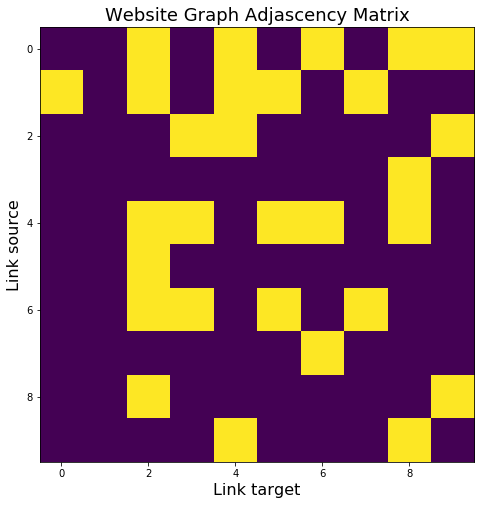

In [25]:
# Number of websites
n = 10

# Adjascency and transition matrices selected randomly
A = np.zeros((n,n))
def dist_func(x):
    return (1.+x)/(1.+x**2)
dist = [dist_func(x)/sum([dist_func(y) for y in range(1,n-1)]) for x in range(1,n-1)]
for i in range(n):
    links = np.random.choice(a=[j for j in range(n) if j != i],size=np.random.choice(a=range(1,n-1),size=1,p=dist))
    A[i,links] = [1]*len(links)
P = np.array([a/sum(a) for a in A])

# Show adjascency matrix in pixelated image format
pyplot.figure(figsize=(8,8))
pyplot.imshow(A)
pyplot.xlabel('Link target',fontsize=16)
pyplot.ylabel('Link source',fontsize=16)
pyplot.title('Website Graph Adjascency Matrix',fontsize=18)
pyplot.show()

# Show interactive jgraph of web links
rows,cols = A.nonzero()
jgraph.draw([(str(i),str(j)) for i,j in zip(rows,cols)],shader='lambert')

## Computing stationary vector and page ranks

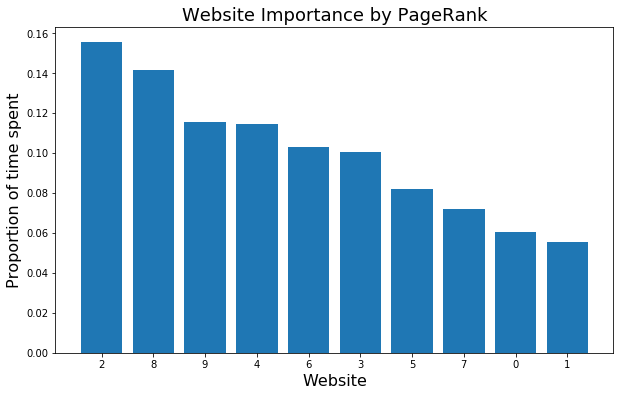

In [26]:
# Modify transition matrix to ensure ergodicity
P_ = 1/9 + (8/9) * P

# Compute eigenvalues and eigenvectors
w,v = np.linalg.eig(P_.T)

# Rearrange eigenvalues and eigenvectors to be in descending order of eigenvalue magnitude
index_order = np.argsort(np.abs(w))[::-1]
w = w[index_order]
v = v[:,index_order]

# Normalize stationary distribution
stationary_dist = np.real(v[:,0])/np.real(sum(v[:,0]))

# Compute pages ranks
page_rank = np.argsort(stationary_dist)[::-1]

# Plot page ranks in descending order of importance
pyplot.figure(figsize=(10,6))
pyplot.bar([str(i) for i in page_rank],np.sort(stationary_dist)[::-1])
pyplot.xlabel('Website',fontsize=16)
pyplot.ylabel('Proportion of time spent',fontsize=16)
pyplot.title('Website Importance by PageRank',fontsize=18)
pyplot.show()

    



In [27]:
# Plot web link visualization with vertex sizes representing website importance
website_graph = { 
                'nodes' : {
                 str(i) : { 'size' : str(500*stationary_dist[i]**3)} for i in range(n)
                    },
                'edges' : [ { 'source' : str(i), 'target' : str(j)} for i,j in zip(rows,cols)]
                }
jgraph.draw(website_graph,shader='lambert')